In [1]:
import sys
sys.path.append("..")
#%%
import deeptrack as dt
import numpy as np
import scipy
import scipy.ndimage
import skimage.measure
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

..\deeptrack\backend\_config.py:12: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  "cupy not installed. GPU-accelerated simulations will not be possible"
..\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


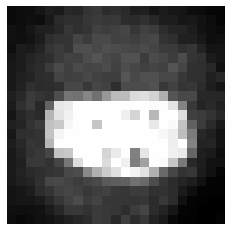

In [2]:
# time, position and size of crop to use for training. 
t, x, y, w = 0, 486, 232, 68
# For very dynamic datasets, it's recommended to downsample first. 
downsample = 3

training_image = dt.LoadImage(f"datasets/Fluo-C2DL-Huh7/01/t{t:03d}.tif")()._value / 256
crop = training_image[y:y+w:downsample, x:x+w:downsample]
plt.imshow(crop, cmap="gray")
plt.axis("off")
plt.show()

In [6]:

model = dt.models.AutoMultiTracker(input_shape=(None, None, 1), loss="mae")
train_set =   (
    dt.Value(crop)
    # Some random augmentations. 
    # Can be reduced if dataset is more homogenous (flat background, similar particles)
    >> dt.Add(lambda: np.random.randn() * 0.15)            
    >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.04))  
    >> dt.Multiply(lambda: np.random.uniform(0.15, 1.1))
)

model.fit(
    train_set,
    epochs=50,
    batch_size=6,
)



Generating 128 / 120 samples before starting training
Epoch 1/50
129/129 [==============================] - 1s 6ms/step - loss: 1.4443 - consistency_loss: 0.6070
Epoch 2/50
129/129 [==============================] - 2s 19ms/step - loss: 0.8563 - consistency_loss: 0.3335
Epoch 3/50
129/129 [==============================] - 3s 21ms/step - loss: 0.7253 - consistency_loss: 0.2130
Epoch 4/50
129/129 [==============================] - 1s 12ms/step - loss: 0.4279 - consistency_loss: 0.1329
Epoch 5/50
129/129 [==============================] - 3s 20ms/step - loss: 0.3651 - consistency_loss: 0.0950
Epoch 6/50
129/129 [==============================] - 3s 20ms/step - loss: 0.3020 - consistency_loss: 0.0632
Epoch 7/50
129/129 [==============================] - 1s 11ms/step - loss: 0.2593 - consistency_loss: 0.0439
Epoch 8/50
129/129 [==============================] - 3s 19ms/step - loss: 0.1980 - consistency_loss: 0.0388
Epoch 9/50
129/129 [==============================] - 3s 20ms/step - loss: 

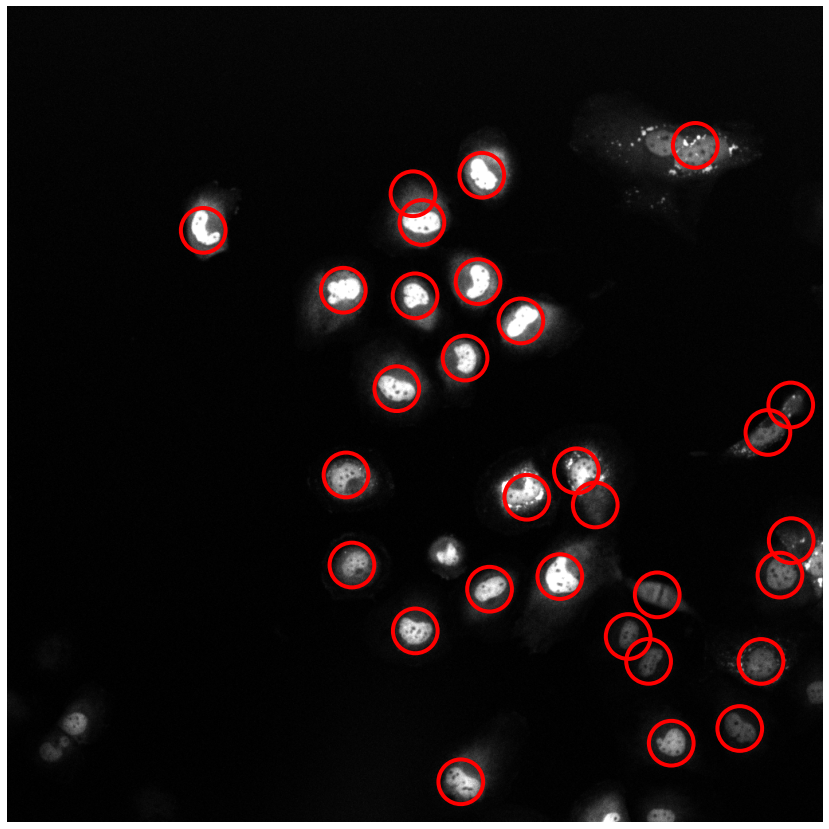

In [25]:
# Optimize these parameters!
# Higher alpha: detect more particles of various shapes.
# Higher cutoff: less detections
alpha = 0.1
cutoff = 0.06




frame_index = 0

image = dt.LoadImage(f"datasets/Fluo-C2DL-Huh7/01/t{t:03d}.tif")()._value / 256
imagein = image[::downsample, ::downsample]

pred, weights = model.predict(imagein[np.newaxis])
detections = dt.models.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant") * downsample

plt.figure(figsize=(15, 15))
plt.imshow(np.log(image + 1), cmap="gray")
plt.axis("off")
plt.scatter(detections[:, 1], detections[:, 0], s=2000, linewidths=4, facecolors="none", edgecolor="r")
plt.show()



In [34]:


TP = 0
FP = 0
FN = 0
tot_predicted = 0
tot_true = 0

alpha = 0.15
cutoff = 0.01

for t in range(29):
    image = dt.LoadImage(f"datasets/Fluo-C2DL-Huh7/01/t{t:03d}.tif")()._value / 256
    mask = dt.LoadImage(f"datasets/Fluo-C2DL-Huh7/01_GT/TRA/man_track{t:03d}.tif")()._value
    imagein=image[::downsample, ::downsample]
    mask = mask[..., 0]

    props = skimage.measure.regionprops(mask)
    true_pos = np.array([p["Centroid"] for p in props])
    
    pred, weights = model.predict(imagein[np.newaxis])
    detections = dt.models.detect(pred[0], weights[0], beta=1-alpha, alpha=alpha, cutoff=cutoff, mode="constant") * downsample

    distances = scipy.spatial.distance.cdist(detections, true_pos)
    row, col = scipy.optimize.linear_sum_assignment(distances)
    assignments = distances[row, col]
    true_det = np.sum(assignments < 15)
    TP += np.sum(assignments < 15)
    FP += detections.shape[0] - true_det
    FN += true_pos.shape[0] - true_det
    tot_predicted += detections.shape[0]
    tot_true += true_pos.shape[0]

print(f"""
    ACCURACIES:
        TPR: {TP / tot_true}
        FPR: {FP / (TP + FP)}
        TP: {TP}
        FP: {FP}
        FN: {FN}
""")


    ACCURACIES:
        TPR: 0.9423286180631121
        FPR: 0.28606760098928274
        TP: 866
        FP: 347
        FN: 53

